Ottawa 67's Project Rebound Classifier

Description: 

We first need to import the required dependencies and will do this below.

In [12]:
from Rebounds import classify_rebounds as cr
from Rebounds import Hockey_Plot as hp
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='adamwilkinson', api_key='Vq7mDLciNvkZExA9e49x')
pd.set_option('display.max_columns', 500)


# Data Exploration
## Initial Inspection

We are working with a dataset given from the Ottawa 67's Hockey club and will run some data manipulation and visualization techniques on it to get a better understanding of what we have. First I will import it into a pandas dataframe and run some basic description functions. Below is some additional information about the dataset we are working with.

<img src="Rebounds/67sDataInfo/all.png" alt="Drawing" style="width: 800px;"/>

In [2]:
shot_df = pd.read_csv('Ottawa67sShotData.csv')
shot_df.head()

,game_date,period,video_time,team_name,strength,position,name,xG,shot category,location,outcome,after rebound,one-timer,deflected,after cross-ice pass,after DzG pass,pass from high zone,pass from medium zone,pass from low zone,pass from perimeter zone,received in high zone,received in medium zone,received in low zone,received in perimeter zone,created rebound,possession after shot,PP,PK,EN,first minute,last minute
0,2018-09-21,1,0 days 00:01:38.000000000,Mississauga Steelheads,5-5,F,Nicholas Canade,0.06,OZ_FORECHECK,MEDIUM,SOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,yes,yes,yes,NaN,NaN,NaN,NaN,NaN
1,2018-09-21,1,0 days 00:02:13.000000000,Mississauga Steelheads,5-5,F,Cole Schwindt,0.04,OFF_OZ,PERIMETER,SOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,NaN,NaN,NaN,NaN,NaN
2,2018-09-21,1,0 days 00:02:52.000000000,Mississauga Steelheads,5-5,F,Cole Carter,0.05,OFF_OZ,MEDIUM,SOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-09-21,1,0 days 00:02:58.000000000,Mississauga Steelheads,5-5,D,Ryan Barbosa,0.01,OZ_FORECHECK,PERIMETER,BLOCKED,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-09-21,1,0 days 00:03:04.000000000,Ottawa 67's,5-5,F,William Sirman,0.01,OFF_OZ,PERIMETER,MISSED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Above we get a look at the first 5 rows of the dataset. We will delve deeper into some of these features later on in the notebook.

In [3]:
shot_df.describe(include='all')

,game_date,period,video_time,team_name,strength,position,name,xG,shot category,location,outcome,after rebound,one-timer,deflected,after cross-ice pass,after DzG pass,pass from high zone,pass from medium zone,pass from low zone,pass from perimeter zone,received in high zone,received in medium zone,received in low zone,received in perimeter zone,created rebound,possession after shot,PP,PK,EN,first minute,last minute
count,6621,6621.000000,6621,6621,6621,6621,6621,6621.000000,6621,6621,6615,283,1656,260,1077,965,151,413,747,3307,585,724,954,2354,2315,2644,1230,161,21,300,371
unique,58,NaN,3115,21,13,3,416,NaN,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,2019-02-08,NaN,0 days 00:33:54.000000000,Ottawa 67's,5-5,F,Tye Felhaber,NaN,OFF_OZ,PERIMETER,SOG,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
freq,139,NaN,8,3615,4936,4344,464,NaN,4585,2010,3407,283,1656,260,1077,965,151,413,747,3307,585,724,954,2354,2315,2644,1230,161,21,300,371
mean,NaN,2.028395,NaN,NaN,NaN,NaN,NaN,0.073977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.834007,NaN,NaN,NaN,NaN,NaN,0.082367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.020000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,0.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,0.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Right away we notice some interesting things. There is a total of 6621 shot attempts in our dataframe. We can see that there are 58 unique game dates implying that out dataset contains shots from 58 games. What is interesting and something we will explore later on in this notebook is that there are 2315 shot attempts that created a rebound and only 283 shots after a rebound. Another useful row is the "top" row. We can see that, as expected the Ottawa 67's have the most shot attempts (as this is data from only their games). Also that most shot attempts occur on 5-5, coming from forwards, after having O-zone pressure and being taken from the perimeter of the ice. These are interesting insights that we will use later on in our analysis.

### Rebounds
We will now take a look at a set of rebounds as determined from the original dataset. 

In [4]:
rebound_df = shot_df[(shot_df['after rebound'] =='yes')]
rebounds_df = rebound_df.reset_index(drop=True)
print('Number of rebounds:', len(rebounds_df))

Number of rebounds: 283


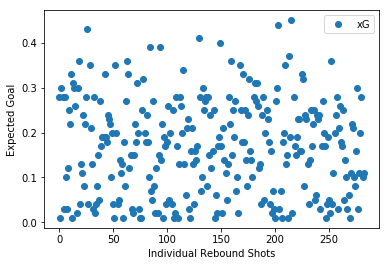

In [5]:
rebounds_plot = rebounds_df.plot(y = 'xG', use_index=True, style='o', )
rebounds_plot.set_xlabel("Individual Rebound Shots");
rebounds_plot.set_ylabel("Expected Goal");

A plot showing that the majority of rebounds lie within an expected goal range of 0% and 30%. It may be interesting to inspect the specific shots that have a greater than 30% expected goal rate. 

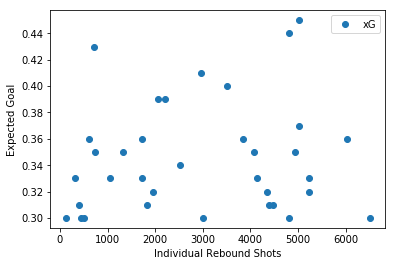

In [6]:
rebounds_df_over30 = rebound_df[rebound_df['xG'] >= 0.3]
rebounds_plot = rebounds_df_over30.plot(y = 'xG', use_index=True, style='o', )
rebounds_plot.set_xlabel("Individual Rebound Shots");
rebounds_plot.set_ylabel("Expected Goal");


In [7]:
rebounds_df_over30.describe(include='all')

,game_date,period,video_time,team_name,strength,position,name,xG,shot category,location,outcome,after rebound,one-timer,deflected,after cross-ice pass,after DzG pass,pass from high zone,pass from medium zone,pass from low zone,pass from perimeter zone,received in high zone,received in medium zone,received in low zone,received in perimeter zone,created rebound,possession after shot,PP,PK,EN,first minute,last minute
count,35,35.000000,35,35,35,35,35,35.000000,35,35,35,35,5,0.0,2,3,4,0.0,0.0,1,4,0.0,0.0,1,13,7,18,2,0.0,4,2
unique,26,NaN,35,12,5,2,24,NaN,3,2,3,1,1,0.0,1,1,1,0.0,0.0,1,1,0.0,0.0,1,1,1,1,1,0.0,1,1
top,2019-01-25,NaN,0 days 00:20:13.000000000,Ottawa 67's,5-4,F,Austen Keating,NaN,OFF_OZ,HIGH,SOG,yes,yes,NaN,yes,yes,yes,NaN,NaN,yes,yes,NaN,NaN,yes,yes,yes,yes,yes,NaN,yes,yes
freq,2,NaN,1,19,13,34,6,NaN,21,33,19,35,5,NaN,2,3,4,NaN,NaN,1,4,NaN,NaN,1,13,7,18,2,NaN,4,2
mean,NaN,2.057143,NaN,NaN,NaN,NaN,NaN,0.346000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,1.027357,NaN,NaN,NaN,NaN,NaN,0.042092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.310000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,0.330000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,0.360000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the table above, we are looking at the rebound attempts with the highest expected goal percentage. It is pretty expected to see the shot location is HIGH, and the shot is generated of extended o-zone pressure. It is also interessting to note that, although the strength doesnt effect the number of rebound attempts, it does however effect the expected goal percentage. Most of the higher expected goals come on the powerplay, as expected.

Below we can see the area on the ice that the rebound attempts are mostly generated. For reference, here is a breakdown of the ice into the specific categories: 
<img src="Rebounds/67sDataInfo/iceBreakdown.png" alt="Drawing" style="width: 200px;"/>

In [8]:
num_df = rebounds_df.replace('yes', 1)
num_df['location'].value_counts()

HIGH         179
PERIMETER     54
MEDIUM        35
LOW           15
Name: location, dtype: int64

Comparing the rebound data to all shot data, we notice that the expected goal "mean" value is more than doubled. 

In [9]:
print('Rebound data: ', num_df['xG'].describe().loc['mean']*100, '%', 
      '\n', 'All shots:', shot_df['xG'].describe().loc['mean']*100, '%')

Rebound data:  16.95053003533569 % 
 All shots: 7.397674067361428 %


We also notice that the percentages for rebounds attempts on the powerplay and penalty kill are similar to the percentages for total shot attempts on the powerplay and penalty kill. This tells us that there is no increase in rebounds at different strengths.

In [10]:
counts_reb = num_df[['PP', 'PK']].describe().loc['count'];

print('Shot Attempts\nTotal:', len(num_df), '\nPP:', counts_reb['PP'], '\nPK:', counts_reb['PK'],
      '\nPercentages\nPP:', (counts_reb['PP']/len(num_df))*100, '%\nPK:', 
      (counts_reb['PK']/len(num_df))*100, '%')


Shot Attempts
Total: 283 
PP: 58.0 
PK: 7.0 
Percentages
PP: 20.49469964664311 %
PK: 2.4734982332155475 %


In [ ]:
labels = ['Even Strength', 'Powerplay', 'Penalty Kill']
values = [(len(num_df)-counts_reb['PP']-counts_reb['PK']), counts_reb['PP'], counts_reb['PK']]
trace = go.Pie(labels=labels, values=values)
plotly.plotly.iplot([trace], filename='Rebounds Pie Chart')

In [56]:
counts_all = shot_df[['PP', 'PK']].describe().loc['count'];

print('Shot Attempts\nTotal:', len(shot_df), '\nPP:', counts_all['PP'], '\nPK:', counts_all['PK'],
      '\nPercentages\nPP:', (counts_all['PP']/len(shot_df))*100, '%\nPK:', 
      (counts_all['PK']/len(shot_df))*100, '%')

Shot Attempts
Total: 6621 
PP: 1230 
PK: 161 
Percentages
PP: 18.57725419120979 %
PK: 2.4316568494185167 %


### Creating Rebounds
We will now explore the label "created rebound" included in the original dataset. 

In [13]:
created_rebound_df = shot_df[shot_df['created rebound'] == 'yes']
# created_rebound_df = created_rebound_df.reset_index(drop=True)
len(created_rebound_df)

2315

In [14]:
both_df = created_rebound_df[created_rebound_df['after rebound'] == 'yes']
len(both_df)

92

We have a total of 2315 shot attempts that lead to a rebound. We wish to remove the shots that both came from a rebound and created one, as this would only occur in a broken down play and can not be easily reproduced.

In [15]:
created_rebound_df = created_rebound_df.drop(list(both_df.index.values))

# PROBABLY WANT TO INCLUDE GRAPHS HERE TO EXPLAIN THINGS

## Custom Classification Algorithm

We will now run our algorithm on the entire dataset to classify the rebounds based on time between shots. We first define a function that converts the time series data into integer form. We require this in order to use the rebound classification algorithm.

In [16]:
#Logic for reformatting the time into integer type
def time_change_logic(df):
    df['video_time_sec'] = 0
    for i in df.index:
        time = df.loc[i, 'video_time'].replace('.000000000','')
        time = time.split('days ')[1]
        time = time.split(':')
        time_min = int(time[0])*60*60 + int(time[1])*60 + int(time[2])
        df.loc[i, 'video_time_sec'] = time_min
    return df

In [17]:
shot_df_integer_time = time_change_logic(shot_df)

In [18]:
#Computationally heavy
rebound_alg_3 = cr.rebound_type(shot_df_integer_time, 'video_time_sec', 3)


In [19]:
rebounds_3 = rebound_alg_3[rebound_alg_3['reb'] == 1]

In [20]:
rebounds_3

,game_date,period,video_time,team_name,strength,position,name,xG,shot category,location,outcome,after rebound,one-timer,deflected,after cross-ice pass,after DzG pass,pass from high zone,pass from medium zone,pass from low zone,pass from perimeter zone,received in high zone,received in medium zone,received in low zone,received in perimeter zone,created rebound,possession after shot,PP,PK,EN,first minute,last minute,video_time_sec,reb,reb1,reb2,reb3
24,2018-09-21,1,0 days 00:13:43.000000000,Mississauga Steelheads,5-5,F,Filip Reisnecker,0.28,OFF_OZ,HIGH,GOAL,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823,1,1,0,0
38,2018-09-21,2,0 days 00:24:43.000000000,Ottawa 67's,5-5,D,Noel Hoefenmayer,0.01,OFF_OZ,PERIMETER,MISSED,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1483,1,0,0,1
78,2018-09-21,3,0 days 00:48:58.000000000,Mississauga Steelheads,5-5,D,Ryan Barbosa,0.02,FACE_OFF,LOW,MISSED,NaN,yes,yes,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,yes,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,2938,1,0,0,1
79,2018-09-21,3,0 days 00:48:59.000000000,Mississauga Steelheads,5-5,F,Richard Whittaker,0.35,FACE_OFF,HIGH,GOAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2939,1,1,0,0
97,2018-09-23,1,0 days 00:00:41.000000000,Peterborough Petes,5-5,F,John Parker-Jones,0.07,OZ_FORECHECK,MEDIUM,BLOCKED,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,yes,NaN,yes,NaN,NaN,NaN,yes,NaN,NaN,NaN,yes,NaN,41,1,1,0,0
110,2018-09-23,1,0 days 00:09:10.000000000,Ottawa 67's,5-5,F,Samuel Bitten,0.21,FACE_OFF,HIGH,SOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550,1,1,0,0
118,2018-09-23,1,0 days 00:11:59.000000000,Peterborough Petes,5-5,F,Chad Denault,0.30,OZ_FORECHECK,HIGH,SOG,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,719,1,0,1,0
126,2018-09-23,1,0 days 00:16:12.000000000,Ottawa 67's,5-5,F,Austen Keating,0.28,OZ_FORECHECK,HIGH,GOAL,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,972,1,1,0,0
144,2018-09-23,2,0 days 00:25:47.000000000,Peterborough Petes,5-5,D,Matt Mcnamara,0.03,OFF_OZ,MEDIUM,MISSED,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,1547,1,0,0,1
149,2018-09-23,2,0 days 00:26:30.000000000,Ottawa 67's,5-5,D,Noel Hoefenmayer,0.04,OZ_FORECHECK,MEDIUM,SOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,1590,1,0,1,0


In [21]:
print(len(rebounds_3), 'rebounds')

543 rebounds


We have labeled 543 rebounds from our original dataset. By comparing this to the "after rebound" label included in the dataset, it is clear that we have classified far more rebounds than pre determined. We first want to see if any pre-classified rebounds were missed by our algorithm and why.

In [22]:
print('Intersection between two algorithms:', len(rebounds_3.index.intersection(rebound_df.index)),
      '\nTotal pre-classified rebounds:', len(rebound_df))

Intersection between two algorithms: 227 
Total pre-classified rebounds: 283


We notice that there are about 50 rebounds that our algorithm missed. We will now inspect these further and determine why. Using the Numpy library we will use setdiff1d to compare indexes. Below we inspect the rows of the dataset to determine why it was classified as a rebound.

In [23]:
miss_by_alg = np.setdiff1d(rebound_df.index, rebounds_3.index)

In [24]:
shot_df.loc[miss_by_alg[0]-1:miss_by_alg[0]]

,game_date,period,video_time,team_name,strength,position,name,xG,shot category,location,outcome,after rebound,one-timer,deflected,after cross-ice pass,after DzG pass,pass from high zone,pass from medium zone,pass from low zone,pass from perimeter zone,received in high zone,received in medium zone,received in low zone,received in perimeter zone,created rebound,possession after shot,PP,PK,EN,first minute,last minute,video_time_sec,reb,reb1,reb2,reb3
329,2018-09-29,1,0 days 00:01:53.000000000,Owen Sound Attack,5-5,F,Griffin Wilson,0.02,OFF_OZ,PERIMETER,SOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,yes,yes,yes,NaN,NaN,NaN,NaN,NaN,113,0,0,0,0
330,2018-09-29,1,0 days 00:01:58.000000000,Owen Sound Attack,5-5,D,Igor Chibrikov,0.01,OFF_OZ,PERIMETER,BLOCKED,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,yes,NaN,yes,NaN,NaN,NaN,NaN,NaN,118,0,0,0,0


In [25]:
shot_df.loc[miss_by_alg[1]-1:miss_by_alg[1]]

,game_date,period,video_time,team_name,strength,position,name,xG,shot category,location,outcome,after rebound,one-timer,deflected,after cross-ice pass,after DzG pass,pass from high zone,pass from medium zone,pass from low zone,pass from perimeter zone,received in high zone,received in medium zone,received in low zone,received in perimeter zone,created rebound,possession after shot,PP,PK,EN,first minute,last minute,video_time_sec,reb,reb1,reb2,reb3
442,2018-09-29,3,0 days 01:00:19.000000000,Owen Sound Attack,5-5,F,Kevin Hancock,0.03,FACE_OFF,PERIMETER,SOG,NaN,yes,yes,yes,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,yes,yes,yes,NaN,NaN,NaN,NaN,NaN,3619,0,0,0,0
443,2018-09-29,3,0 days 01:00:24.000000000,Owen Sound Attack,5-5,F,Aidan Dudas,0.30,OFF_OZ,HIGH,SOG,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,3624,0,0,0,0


In [26]:
shot_df.loc[miss_by_alg[10]-1:miss_by_alg[10]]

,game_date,period,video_time,team_name,strength,position,name,xG,shot category,location,outcome,after rebound,one-timer,deflected,after cross-ice pass,after DzG pass,pass from high zone,pass from medium zone,pass from low zone,pass from perimeter zone,received in high zone,received in medium zone,received in low zone,received in perimeter zone,created rebound,possession after shot,PP,PK,EN,first minute,last minute,video_time_sec,reb,reb1,reb2,reb3
1725,2018-10-28,1,0 days 00:00:49.000000000,Ottawa 67's,5-5,D,Noel Hoefenmayer,0.07,OFF_OZ,MEDIUM,SOG,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,yes,NaN,NaN,yes,yes,NaN,NaN,NaN,yes,NaN,49,1,1,0,0
1726,2018-10-28,1,0 days 00:00:53.000000000,Ottawa 67's,5-5,F,Alexander Chmelevski,0.33,OFF_OZ,PERIMETER,SOG,yes,yes,NaN,yes,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,yes,yes,yes,NaN,NaN,NaN,yes,NaN,53,0,0,0,0


By this investigation, it appears that shots following the initial shot by more than 3 seconds are included in the pre-classified rebounds. We will leave these out of our analysis.

We will now split this set into 67's shots and other, then examine the locations of said rebounds.

In [27]:
ottawa_rebounds = rebounds_3[rebounds_3['team_name'] == "Ottawa 67's"]
other_rebounds = rebounds_3[rebounds_3['team_name'] != "Ottawa 67's"]

print("Ottawa rebounds:", len(ottawa_rebounds),'\nOther team rebounds:', len(other_rebounds))

Ottawa rebounds: 291 
Other team rebounds: 252


In [28]:
ottawa_rebounds_1 = ottawa_rebounds[ottawa_rebounds['reb1'] == 1]
print('One second rebounds:', len(ottawa_rebounds_1))

One second rebounds: 129


In [29]:
ottawa_rebounds_2 = ottawa_rebounds[ottawa_rebounds['reb2'] == 1]
print('Two second rebounds:', len(ottawa_rebounds_2))

One second rebounds: 97


In [30]:
ottawa_rebounds_3 = ottawa_rebounds[ottawa_rebounds['reb3'] == 1]
print('Three second rebounds:', len(ottawa_rebounds_3))

One second rebounds: 65


#### Ottawa 67's rebound locations
Going back to our initial classification of 3 second rebounds we will determine the most common locations of shots.
<img src="Rebounds/67sDataInfo/iceBreakdown.png" alt="Drawing" style="width: 200px;"/>

In [31]:
ottawa_rebounds['location'].value_counts()

HIGH         154
PERIMETER     65
MEDIUM        50
LOW           22
Name: location, dtype: int64

In [55]:
plotly.plotly.iplot(hp.plot_rebounds(ottawa_rebounds['location'].value_counts()[3],
                 int((ottawa_rebounds['location'].value_counts()[2])*0.5),
                 ottawa_rebounds['location'].value_counts()[0],
                 int((ottawa_rebounds['location'].value_counts()[1])*0.5)), filename="hockey_plot")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~adamwilkinson/0 or inside your plot.ly account where it is named 'hockey_plot'


We now split the dataset based on additional statistics that may provide us with interesting insight.

### Goals

##### ALL REBOUNDS

In [36]:
ottawa_rebounds_goal = ottawa_rebounds[ottawa_rebounds['outcome'] == "GOAL"]
ottawa_rebounds_goal['location'].value_counts()

HIGH         44
PERIMETER     4
MEDIUM        1
LOW           1
Name: location, dtype: int64

In [57]:
plotly.plotly.iplot(hp.plot_rebounds(ottawa_rebounds_goal['location'].value_counts()[3],
                 int((ottawa_rebounds_goal['location'].value_counts()[2])*0.5),
                 ottawa_rebounds_goal['location'].value_counts()[0],
                 int((ottawa_rebounds_goal['location'].value_counts()[1])*0.5)), filename="hockey_plot")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~adamwilkinson/0 or inside your plot.ly account where it is named 'hockey_plot'


In [37]:
ottawa_rebounds_goal[ottawa_rebounds_goal['one-timer'] == 'yes']


,game_date,period,video_time,team_name,strength,position,name,xG,shot category,location,outcome,after rebound,one-timer,deflected,after cross-ice pass,after DzG pass,pass from high zone,pass from medium zone,pass from low zone,pass from perimeter zone,received in high zone,received in medium zone,received in low zone,received in perimeter zone,created rebound,possession after shot,PP,PK,EN,first minute,last minute,video_time_sec,reb,reb1,reb2,reb3
4494,2019-01-11,1,0 days 00:00:47.000000000,Ottawa 67's,5-5,F,Samuel Bitten,0.20,OFF_OZ,HIGH,GOAL,NaN,yes,NaN,NaN,yes,yes,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,47,1,1,0,0
5011,2019-01-19,2,0 days 00:25:00.000000000,Ottawa 67's,5-4,F,Marco Rossi,0.37,OFF_OZ,HIGH,GOAL,yes,yes,NaN,NaN,yes,yes,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,1500,1,0,0,1


##### 1 SECOND REBOUNDS

In [38]:
ottawa_rebounds_1_goal = ottawa_rebounds_1[ottawa_rebounds_1['outcome'] == "GOAL"]
ottawa_rebounds_1_goal['location'].value_counts()

HIGH         30
MEDIUM        1
PERIMETER     1
Name: location, dtype: int64

##### 2 SECOND REBOUNDS

In [39]:
ottawa_rebounds_2_goal = ottawa_rebounds_2[ottawa_rebounds_2['outcome'] == "GOAL"]
ottawa_rebounds_2_goal['location'].value_counts()

HIGH         12
PERIMETER     1
Name: location, dtype: int64

##### 3 SECOND REBOUNDS

In [40]:
ottawa_rebounds_3_goal = ottawa_rebounds_3[ottawa_rebounds_3['outcome'] == "GOAL"]
ottawa_rebounds_3_goal['location'].value_counts()

PERIMETER    2
HIGH         2
LOW          1
Name: location, dtype: int64

### SOG

In [41]:
ottawa_rebounds_SOG = ottawa_rebounds[ottawa_rebounds['outcome'] == "SOG"]
ottawa_rebounds_SOG['location'].value_counts()

HIGH         82
PERIMETER    26
MEDIUM       22
LOW          10
Name: location, dtype: int64

In [58]:
plotly.plotly.iplot(hp.plot_rebounds(ottawa_rebounds_SOG['location'].value_counts()[3],
                 int((ottawa_rebounds_SOG['location'].value_counts()[2])*0.5),
                 ottawa_rebounds_SOG['location'].value_counts()[0],
                 int((ottawa_rebounds_SOG['location'].value_counts()[1])*0.5)), filename="hockey_plot")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~adamwilkinson/0 or inside your plot.ly account where it is named 'hockey_plot'


### MISSED

In [42]:
ottawa_rebounds_missed = ottawa_rebounds[ottawa_rebounds['outcome'] == "MISSED"]
ottawa_rebounds_missed['location'].value_counts()

HIGH         20
PERIMETER    18
MEDIUM       14
LOW           7
Name: location, dtype: int64

### BLOCKED

In [43]:
ottawa_rebounds_blocked = ottawa_rebounds[ottawa_rebounds['outcome'] == "BLOCKED"]
ottawa_rebounds_blocked['location'].value_counts()

PERIMETER    17
MEDIUM       13
HIGH          8
LOW           4
Name: location, dtype: int64

In [59]:
plotly.plotly.iplot(hp.plot_rebounds(ottawa_rebounds_blocked['location'].value_counts()[3],
                 int((ottawa_rebounds_blocked['location'].value_counts()[2])*0.5),
                 ottawa_rebounds_blocked['location'].value_counts()[0],
                 int((ottawa_rebounds_blocked['location'].value_counts()[1])*0.5)), filename="hockey_plot")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~adamwilkinson/0 or inside your plot.ly account where it is named 'hockey_plot'


# Use the Hockey_plot function to plot random points?